### 1. Load Data Set and Python Packages

#### Load Python Packages

In [706]:
import random
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("whitegrid")

from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

#### Load and Display Data Set

In [538]:
# load data set
data = pd.read_csv('Appointment_data.csv')

In [440]:
# display appointment data set
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [441]:
# displace data volumn and types 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### 2. Data Quality Assessment

#### Check Missing Values

In [442]:
# check if data set contains missing values
print(data.isnull().sum())

# assert that there are no missing values
assert data.notnull().all().all()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


No missing value exist in this data set.

#### Check Duplicated Values

In [443]:
# check if data set contains duplicated appointment ID
print(data.AppointmentID.duplicated().sum())

0


There is no duplicated appointments record in this data set. The data is clean.

In [444]:
# check if data set contains duplicated patient ID
data.PatientId = data.PatientId.astype(int)
data.PatientId.duplicated().sum()

48228

48228 out of 110527 (~43.6%) patients have more than one appointment records in this data set.

Some people may constantly have higher probability of not-show. We will explore more on this in EDA part.

#### Check Category Variables

In [445]:
# check categories in category variables
print(f"Gender: {set(data.Gender)}")
print(f"Scholarship: {set(data.Scholarship)}")
print(f"Hipertension: {set(data.Hipertension)}")
print(f"Diabetes: {set(data.Diabetes)}")
print(f"Handcap: {set(data.Handcap)}")
print(f"SMS_received: {set(data.SMS_received)}")
print(f"SMS_received: {set(data.SMS_received)}")
print(f"No-show: {set(data['No-show'])}")

# check number of categories in variable 'Neighbourhood'
num_neigh = len(set(data.Neighbourhood))
print(f'Number of different neighbourhood: {num_neigh}')

Gender: {'M', 'F'}
Scholarship: {0, 1}
Hipertension: {0, 1}
Diabetes: {0, 1}
Handcap: {0, 1, 2, 3, 4}
SMS_received: {0, 1}
SMS_received: {0, 1}
No-show: {'Yes', 'No'}
Number of different neighbourhood: 81


Based on above summary, we will do two more assessment:

- variable name "No-show" and its categories are ambiguous, rename it.
- variable "Handcap" is not binary, check its distribution.

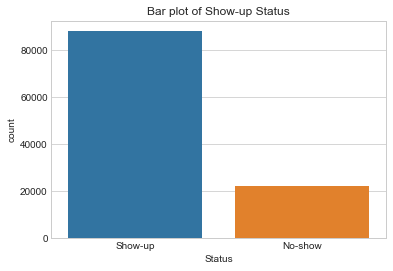

Percentage of Show-up Status: 


Show-up    79.806744
No-show    20.193256
Name: Status, dtype: float64

In [539]:
# rename No-show column to Status and set "No" to "Show-up", "Yes" to "No-show"
data.rename(columns = {"No-show": "Status"}, inplace=True)
data.Status = data.Status.astype('category').cat.rename_categories(['Show-up', 'No-show'])

# plot distribution of Show-up Status
sns.countplot(x="Status", data=data)
plt.title("Bar plot of Show-up Status")
plt.show()
print("Percentage of Show-up Status: ")
100 * data['Status'].value_counts()/len(data)

From the above chart we see that there are around 80% of the patients who have turned up. We see a clear class imbalance problem here. A naive approach of predicting that every one shows up gives us an accuracy of 0.8.

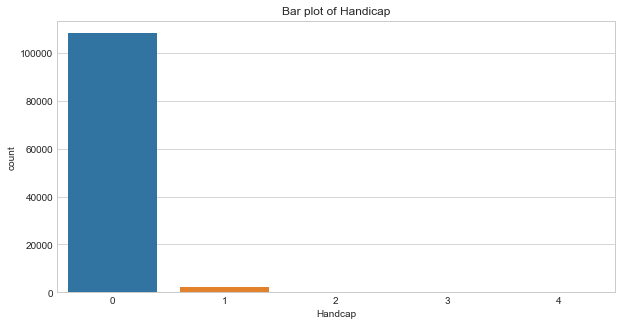

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [540]:
# variable "Handcap" is not binary, check its distribution
plt.figure(figsize=(10,5))
sns.countplot(x="Handcap", data=data)
plt.title('Bar plot of Handicap')
plt.show()
data.Handcap.value_counts()

The different categories of handicap may stand for different levels of disability.

We can create a binary variable representing not handicap(0) and handicap(1) for future comparing.

In [541]:
# create a binary variable "Handicap"
data['Handicap'] = (data.Handcap!=0).astype(int)

#### Check Numerical Variables

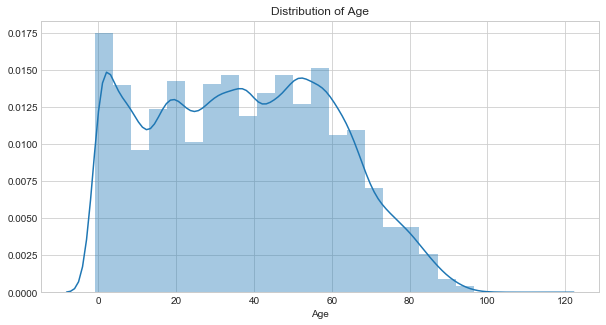

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

In [449]:
# check value distribution of variable "Age"
plt.figure(figsize=(10,5))
sns.distplot(data.Age, bins=25)
plt.title("Distribution of Age")
plt.xlabel('Age')
plt.show()
data.Age.describe()

Negative values appear in "Age", we will take a closer look at it.

In [542]:
# check how many negative values are there in "Age" variable
print(f'Number of "Age" that have negative value: {sum(data.Age<0)}')

# remove the negative value from data set because it is apparently not valid
data = data[data.Age >= 0].reset_index()
print("Remove the negative age from data set because it is apparently not valid.")

Number of "Age" that have negative value: 1
Remove the negative age from data set because it is apparently not valid.


### 3. Exploratory Data Analysis and Feature Selection

#### Exploring on "ScheduledDay" and "AppointmentDay"

In [451]:
# display 'ScheduledDay' and 'AppointmentDay'
data.loc[:,['PatientId', 'AppointmentID', 'ScheduledDay','AppointmentDay']].head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay
0,29872499824296,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z
1,558997776694438,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z
2,4262962299951,5642549,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z
3,867951213174,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z
4,8841186448183,5642494,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z


"ScheduledDay" and "AppointmentDay" can not be directly use for analysis, we will extract following information from the two variables:

- month in ScheduledDayd
- week day in ScheduledDay
- month in AppointmentDay
- week day in AppointmentDay
- awaiting days(AppointmentDay_Date - ScheduledDay_Date)

The "AppointmentDay" does not contain precise appointment time(in hour), hence we cannot obtain this information from the data set.

In [543]:
# create a new column "ScheduledDay_Date" containing the date in ScheduledDay.
data['ScheduledDay_Date'] = data.ScheduledDay.str.extract('(\d{4}-\d{2}-\d{2})', expand=True)

# create a new column "ScheduledDay_Month" containing the month in ScheduledDay.
data['ScheduledDay_Month'] = data.ScheduledDay_Date.str.extract('(\d{4}-)(\d{2})(-\d{2})', expand=True)[1].str.replace('0','')

# create a new column "ScheduledDay_Weekday" containing the week day in ScheduledDay.
data['ScheduledDay_Weekday'] = pd.to_datetime(data.ScheduledDay_Date).dt.weekday_name

# create a new column "AppointmentDay_Date" containing the date in AppointmentDay.
data['AppointmentDay_Date'] = data.AppointmentDay.str.extract('(\d{4}-\d{2}-\d{2})', expand=True)

# create a new column "AppointmentDay_Month" containing the month in AppointmentDay.
data['AppointmentDay_Month'] = data.AppointmentDay_Date.str.extract('(\d{4}-)(\d{2})(-\d{2})', expand=True)[1].str.replace('0','')

# create a new column "AppointmentDay_Weekday" containing the week day in AppointmentDay.
data['AppointmentDay_Weekday'] = pd.to_datetime(data.AppointmentDay_Date).dt.weekday_name

# create a new column "Awaiting_Days" containing only the awaiting time in days(AppointmentDay_Date - ScheduledDay_Date).
data['Awaiting_Days'] = ((pd.to_datetime(data.AppointmentDay_Date)-pd.to_datetime(data.ScheduledDay_Date))/np.timedelta64(1, 'D')).astype(int)

# display new columns
data.loc[:,['PatientId', 'AppointmentID', 'ScheduledDay_Date', 'ScheduledDay_Month', 'ScheduledDay_Weekday', 'AppointmentDay_Date', 'AppointmentDay_Month', 'AppointmentDay_Weekday', 'Awaiting_Days']].head()

,PatientId,AppointmentID,ScheduledDay_Date,ScheduledDay_Month,ScheduledDay_Weekday,AppointmentDay_Date,AppointmentDay_Month,AppointmentDay_Weekday,Awaiting_Days
0,2.987250e+13,5642903,2016-04-29,4,Friday,2016-04-29,4,Friday,0
1,5.589978e+14,5642503,2016-04-29,4,Friday,2016-04-29,4,Friday,0
2,4.262962e+12,5642549,2016-04-29,4,Friday,2016-04-29,4,Friday,0
3,8.679512e+11,5642828,2016-04-29,4,Friday,2016-04-29,4,Friday,0
4,8.841186e+12,5642494,2016-04-29,4,Friday,2016-04-29,4,Friday,0


Let's plot out these new variables and see what kind of relationship it has with Show-up Rate. 

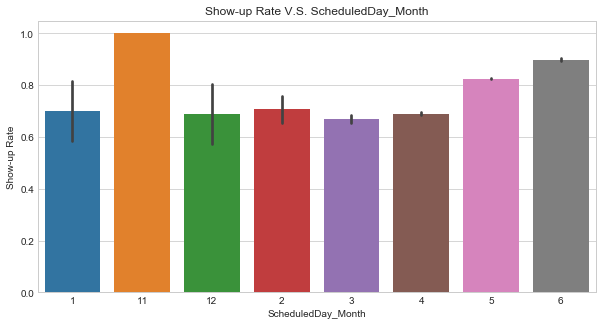

Number of records on each month: 
5     67421
4     25339
6     13749
3      3614
2       281
12       61
1        60
11        1
Name: ScheduledDay_Month, dtype: int64


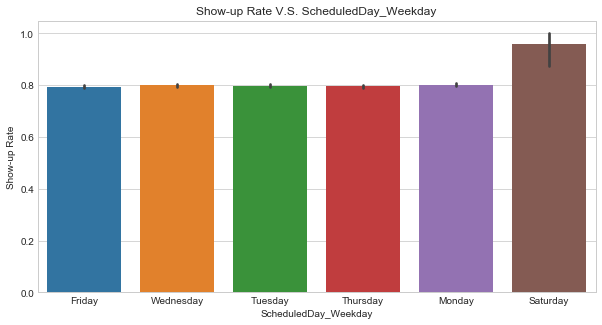

Number of records on each weekday: 
Tuesday      26168
Wednesday    24262
Monday       23084
Friday       18915
Thursday     18073
Saturday        24
Name: ScheduledDay_Weekday, dtype: int64


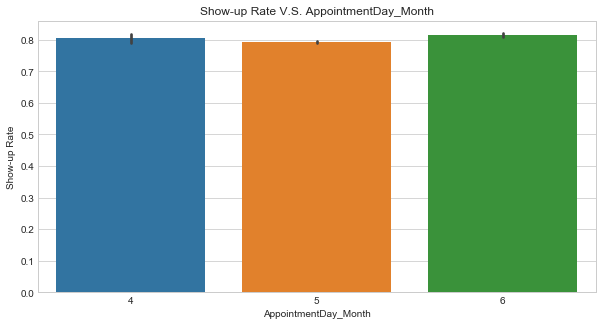

Number of records on each month: 
5    80841
6    26450
4     3235
Name: AppointmentDay_Month, dtype: int64


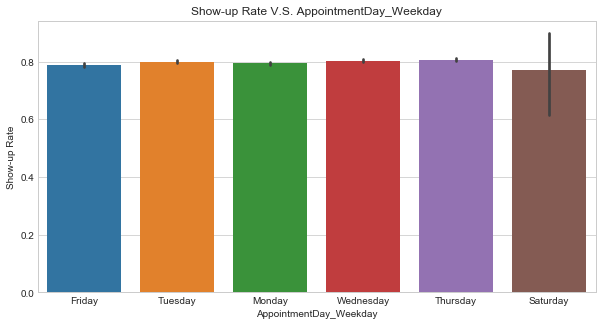

Number of records on each weekday: 
Wednesday    25867
Tuesday      25640
Monday       22714
Friday       19019
Thursday     17247
Saturday        39
Name: AppointmentDay_Weekday, dtype: int64


In [544]:
# copy data to time_analysis and transform "Status" to dummy variable
time_analysis = data.copy()
time_analysis.Status = time_analysis.Status.astype('category').cat.rename_categories([1, 0]).astype(int)

# plot Show-up Rate V.S. ScheduledDay_Month
plt.figure(figsize=(10,5))
sns.barplot(x="ScheduledDay_Month", y="Status", data=time_analysis)
plt.title('Show-up Rate V.S. ScheduledDay_Month')
plt.ylabel("Show-up Rate")
plt.show()
# number of records on each ScheduledDay_Month
print("Number of records on each month: ")
print(time_analysis.ScheduledDay_Month.value_counts())

# plot Show-up Rate V.S. ScheduledDay_Weekday
plt.figure(figsize=(10,5))
sns.barplot(x="ScheduledDay_Weekday", y="Status", data=time_analysis)
plt.title('Show-up Rate V.S. ScheduledDay_Weekday')
plt.ylabel("Show-up Rate")
plt.show()
# number of records on each ScheduledDay_Weekday
print("Number of records on each weekday: ")
print(time_analysis.ScheduledDay_Weekday.value_counts())

# plot Show-up Rate V.S. AppointmentDay_Month
plt.figure(figsize=(10,5))
sns.barplot(x="AppointmentDay_Month", y="Status", data=time_analysis)
plt.title('Show-up Rate V.S. AppointmentDay_Month')
plt.ylabel("Show-up Rate")
plt.show()
# number of records on each AppointmentDay_Month
print("Number of records on each month: ")
print(time_analysis.AppointmentDay_Month.value_counts())

# plot Show-up Rate V.S. AppointmentDay_Weekday
plt.figure(figsize=(10,5))
sns.barplot(x="AppointmentDay_Weekday", y="Status", data=time_analysis)
plt.title('Show-up Rate V.S. AppointmentDay_Weekday')
plt.ylabel("Show-up Rate")
plt.show()
# number of records on each AppointmentDay_Weekday
print("Number of records on each weekday: ")
print(time_analysis.AppointmentDay_Weekday.value_counts())

Let's firstly look at Show-up Rate V.S. AppointmentDay_Month. The show-up rate in each month are nearly the same, in other words, it is very close to a uniform distribution. Because there is no evidence showing AppointmentDay_Month has any relationship with show-up rate, it is not a good attribute for machine learning model. 

Show-up Rate V.S. ScheduledDay_Month gives us some insteresting insights. Month 1,2,3,4,12 have a small difference in show-up rate. Month 11 have extremely high show-up rate (100%), however, cause there is only one record existing in this month, we will treat it as a bias. Month 5 and 6 have high show-up rate compared with other months. We can create a binary variable for scheduled month 5 and 6.

Show-up Rate V.S. AppointmentDay_Weekday does not give us any useful insight, it is very close to a uniform distribution. AppointmentDay_Weekday is not a good attribute for machine learning model.

Show-up Rate V.S. ScheduledDay_Weekday does not give us any useful insight, it is very close to a uniform distribution. Although Saturday is obviously higher than other weekdays, number of records on this day are too small. AppointmentDay_Weekday is not a good attribute for machine learning model.

In [545]:
# create a binary variable "If_ScheduledMonth56"
data['If_ScheduledMonth56'] = data.ScheduledDay_Month.isin(['5','6']).astype(int)

Next, we will explore the relationship between Awaiting Days and Show-Up rate.

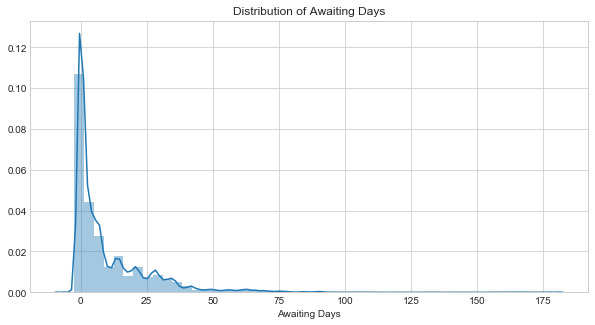

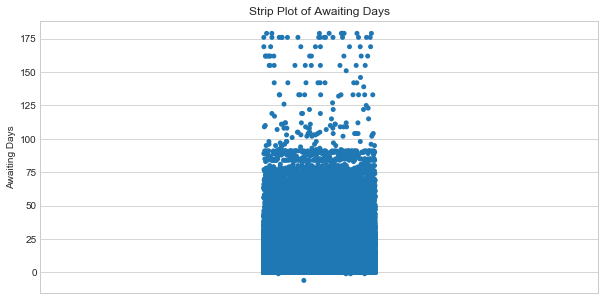

count    110526.000000
mean         10.183794
std          15.255034
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: Awaiting_Days, dtype: float64

In [455]:
# check value distribution of variable "Awaiting_Days" - distplot
plt.figure(figsize=(10,5))
sns.distplot(data.Awaiting_Days)
plt.title("Distribution of Awaiting Days")
plt.xlabel('Awaiting Days')

# check value distribution of variable "Awaiting_Days" - stripplot
plt.figure(figsize=(10,5))
sns.stripplot(data = time_analysis, y = 'Awaiting_Days', jitter = True)
plt.title("Strip Plot of Awaiting Days")
plt.ylabel("Awaiting Days")
plt.xlabel("")

plt.show()

data.Awaiting_Days.describe()

Negative values appear in "Awaiting Days", we will take a closer look at it.

In [546]:
# check how many negative values are there in "Awaiting Days" variable
print(f'Number of "Awaiting Days" that have negative value: {sum(data.Awaiting_Days<0)}')

# remove the negative values from data set because they are apparently not valid
data = data[data.Awaiting_Days >= 0].reset_index()
print("Remove the negative awaiting days from data set because they are apparently not valid.")

Number of "Awaiting Days" that have negative value: 5
Remove the negative awaiting days from data set because they are apparently not valid.


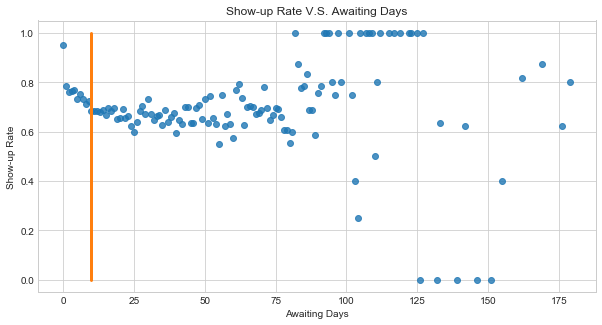

Day  Num_Record  Num_Record_Perc  Showup_Rate
  0       38562            34.89     0.953529
  1        5213             4.72     0.786495
  2        6725             6.08     0.761784
  3        2737             2.48     0.764706
  4        5290             4.79     0.767297
  5        3277             2.97     0.733903
  6        4037             3.65     0.752044
  7        4906             4.44     0.733184
  8        2332             2.11     0.712693
  9        1605             1.45     0.725857
 10        1391             1.26     0.683681
Awaiting time for less than or equal to 10 days represent 68.84% of data in entire data set.


In [457]:
# copy data to time_analysis and transform "Status" to dummy variable
time_analysis = data.copy()
time_analysis.Status = time_analysis.Status.astype('category').cat.rename_categories([1, 0]).astype(int)

# calculate number of records for each "Awaiting Day"
awaiting_valuecount = time_analysis.Awaiting_Days.value_counts()
awaiting_valuecount = pd.DataFrame({"day": awaiting_valuecount.index.values, "num_record": np.array(awaiting_valuecount)})
awaiting_valuecount = awaiting_valuecount.sort_values(by=['day'], ascending=True)
awaiting_valuecount['num_record_perc'] = round(100 * awaiting_valuecount.num_record/len(data),2)

# group by Awaiting Days and calculate its show-up rate
showup_rate = time_analysis.groupby("Awaiting_Days")["Status"].mean()
day = np.sort(time_analysis.Awaiting_Days.unique())
awaiting_analysis = pd.DataFrame({"Day":day, "Showup_Rate":np.array(showup_rate), "Num_Record":np.array(awaiting_valuecount.num_record), "Num_Record_Perc": np.array(awaiting_valuecount.num_record_perc)})

# plot Showup Rate V.S. Awaiting Days 
plt.figure(figsize=(10,5))
sns.regplot(x="Day", y="Showup_Rate", data=awaiting_analysis, ci=False, fit_reg=False)
plt.plot([10, 10], [1, 0], linewidth=3)
plt.title("Show-up Rate V.S. Awaiting Days")
plt.xlabel('Awaiting Days')
plt.ylabel('Show-up Rate')
plt.show()
print(awaiting_analysis.head(11).to_string(index=False))
perc_top10 = round(sum(awaiting_analysis.Num_Record_Perc.head(11)),2)
print(f"Awaiting time for less than or equal to 10 days represent {perc_top10}% of data in entire data set.")

Although the entire distribution of Showup Rate V.S. Awaiting Days does not show a strong relationship, awaiting time for less than or equal to 10 days show a distinctly negative relationship. Especially, people who scheduled his/her appoinment on the same day will have a obviously high show-up rate and this type of situation represent 34.89% of data in entire data set.

We will create one binary variable to represent:

- People who scheduled his/her appoinment on the same day

For those points that reach either 1 or 0 show-up rate are caused by too small sample size on that "Awaiting Days".

In [547]:
# create a binary variable "If_0Await"
data['If_0Await'] = (data.Awaiting_Days==0).astype(int)

#### Exploring on given binary dummy variables

Variables include: Scholarship, Hipertension, Diabetes, Alcoholism, Handicap, SMS_received

In [548]:
# copy data to dummy_analysis and transform "Status" to dummy variable
dummy_analysis = data.copy()
dummy_analysis.Status = dummy_analysis.Status.astype('category').cat.rename_categories([1, 0]).astype(int)

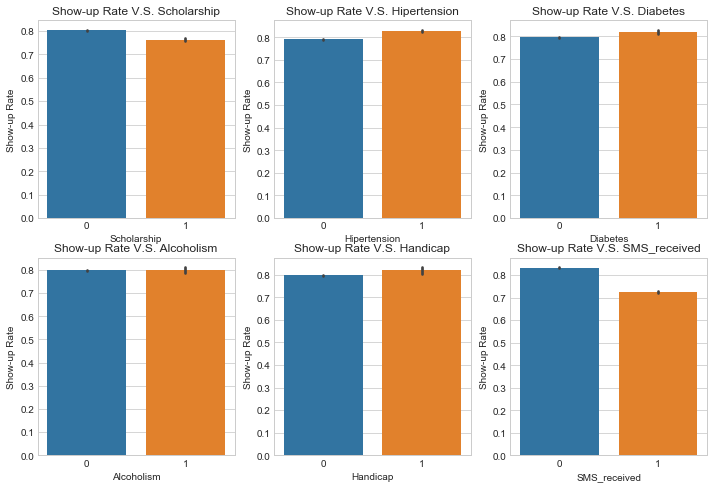

In [460]:
# plot Show-up Rate V.S. Binary Dummy Variables
plt.figure(figsize=(12,8))
plt.subplot(2, 3, 1)
sns.barplot(x="Scholarship", y="Status", data=dummy_analysis)
plt.title('Show-up Rate V.S. Scholarship')
plt.ylabel("Show-up Rate")

plt.subplot(2, 3, 2)
sns.barplot(x="Hipertension", y="Status", data=dummy_analysis)
plt.title('Show-up Rate V.S. Hipertension')
plt.ylabel("Show-up Rate")

plt.subplot(2, 3, 3)
sns.barplot(x="Diabetes", y="Status", data=dummy_analysis)
plt.title('Show-up Rate V.S. Diabetes')
plt.ylabel("Show-up Rate")

plt.subplot(2, 3, 4)
sns.barplot(x="Alcoholism", y="Status", data=dummy_analysis)
plt.title('Show-up Rate V.S. Alcoholism')
plt.ylabel("Show-up Rate")

plt.subplot(2, 3, 5)
sns.barplot(x="Handicap", y="Status", data=dummy_analysis)
plt.title('Show-up Rate V.S. Handicap')
plt.ylabel("Show-up Rate")

plt.subplot(2, 3, 6)
sns.barplot(x="SMS_received", y="Status", data=dummy_analysis)
plt.title('Show-up Rate V.S. SMS_received')
plt.ylabel("Show-up Rate")

plt.show()

Show-up Rate V.S. Alcoholism shows a uniform distribution. Either Alcoholism or not Alcoholism have around 80% Show-up rate, this feature may not add much value while building a model.

The distribution of Show-up Rate V.S. SMS_received does not make sense. People who do receive a reminder SMS usually tend to visit the hospital more than those who haven't received an SMS. This discrepancy may cause by human error when collecting data. Or this could be an SMS that was recived while booking an appointment and could possibly have no correlation with the visit probability.

Hence, "Alcoholism" and "SMS_received" are not good predictors for machine learning model.

#### Exploring on "Neighbourhood"

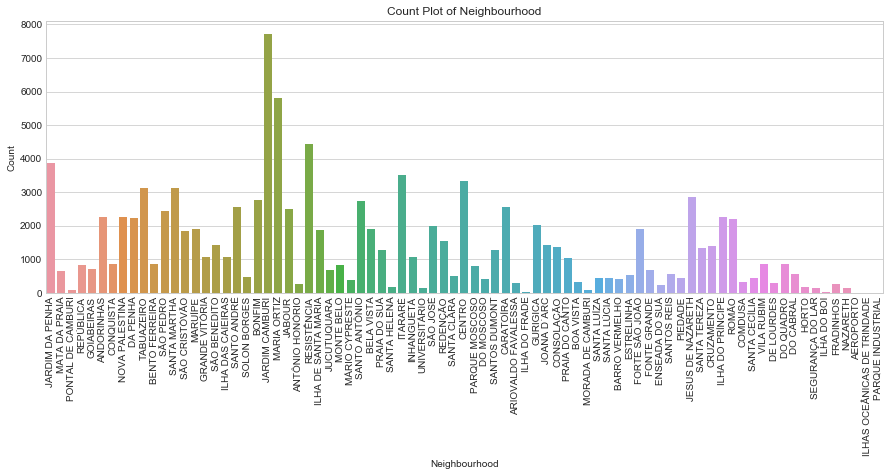

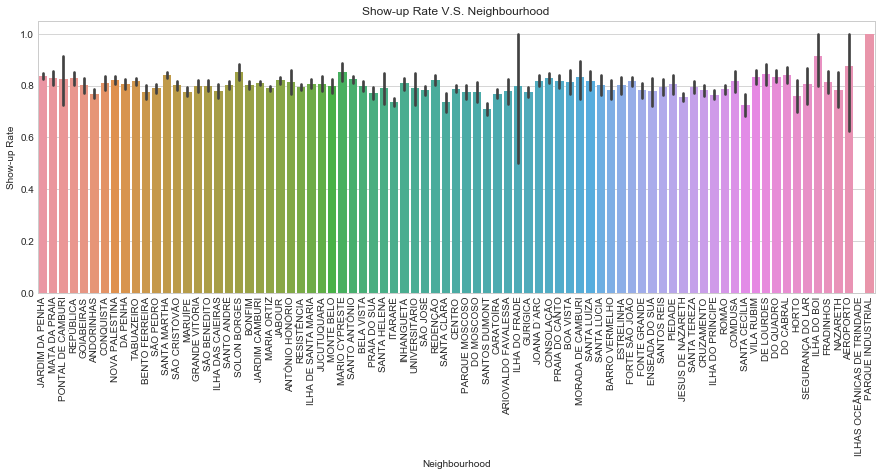

In [461]:
# plot distribution of variable Neighbourhood
plt.figure(figsize=(15,5))
sns.countplot(x="Neighbourhood", data=dummy_analysis)
plt.xticks(rotation=90)
plt.title("Count Plot of Neighbourhood")
plt.xlabel('Neighbourhood')
plt.ylabel("Count")
plt.show()

# plot Show-up Rate V.S. Neighbourhood
plt.figure(figsize=(15,5))
sns.barplot(x="Neighbourhood", y="Status", data=dummy_analysis)
plt.xticks(rotation=90)
plt.title('Show-up Rate V.S. Neighbourhood')
plt.ylabel("Show-up Rate")
plt.show()

From the Count Plot of Neighbourhood, we can see that the number of patients for few Neighbourhood's is very high.

The distribution of Show-up Rate V.S. Neighbourhood is close to uniform. Show-up Rate may not stongly relavent to location.

Hence, "Neighbourhood" may not play an important role in determining if a patient comes for a visit or not.

#### Exploring on "Age"

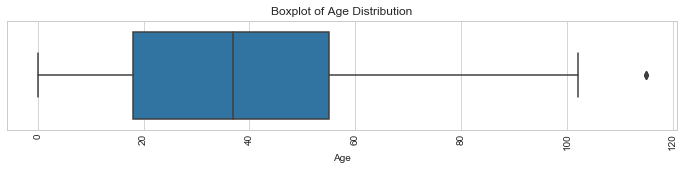

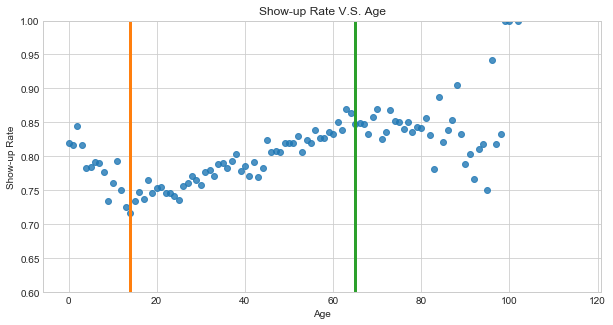

In [462]:
age_showup_rate = dummy_analysis.groupby(['Age'])['Status'].mean()
age_showup_rate = pd.DataFrame({"Age": age_showup_rate.index, "Showup_Rate": np.array(age_showup_rate)})

# boxplot of Age distribution
plt.figure(figsize=(12,2))
sns.boxplot(x="Age", data=dummy_analysis)
plt.xticks(rotation=90)
plt.title("Boxplot of Age Distribution")
plt.show()

# scatter plot of Show-up Rate V.S. Age
plt.figure(figsize=(10,5))
sns.regplot(x="Age", y="Showup_Rate", data=age_showup_rate, ci=False, fit_reg=False)
plt.ylim(0.6,1)
plt.plot([14, 14], [1, 0], linewidth=3)
plt.plot([65, 65], [1, 0], linewidth=3)
plt.title("Show-up Rate V.S. Age")
plt.xlabel('Age')
plt.ylabel('Show-up Rate')
plt.show()

From the above Boxplot we can see that the Median Age is around 35 and the IQR is between 18 and 55. Though the BoxPlot shows few datapoints as outliers we will not consider them as true outliers for this case.

The Scatter plot of Show-up Rate V.S. Age shows an obvious piecewise relationship.

- Age 0-14: negatively related between Age and Show-up Rate
- Age 15-65: positively related between Age and Show-up Rate
- Age above 65: no clear relationship

#### Exploring on "Gender"

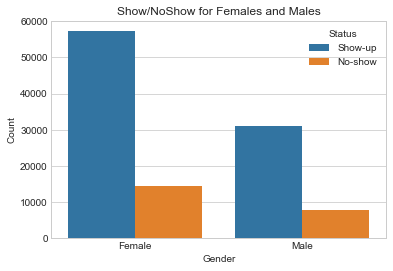

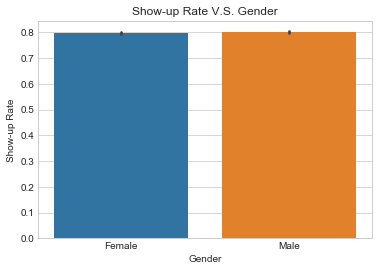

In [463]:
# plot Show/NoShow for Females and Males
sns.countplot(x="Gender", hue="Status", data=data).set_xticklabels(['Female', 'Male'])
plt.title("Show/NoShow for Females and Males")
plt.ylabel("Count")
plt.show()

# plot Show-up Rate V.S. Gender
sns.barplot(x="Gender", y="Status", data=dummy_analysis).set_xticklabels(['Female', 'Male'])
plt.title('Show-up Rate V.S. Gender')
plt.ylabel("Show-up Rate")
plt.show()

From the above visualization we can clearly see that 'Female' patients usually have more appointments that 'Male' patients. So, Gender might be an important factor. But if we closely look at the NoShow distribution across Male's and Female's it is almost the same. So, Gender may not play an important role in determining if a patient comes for a visit or not.

#### Exploring on "PatientId"

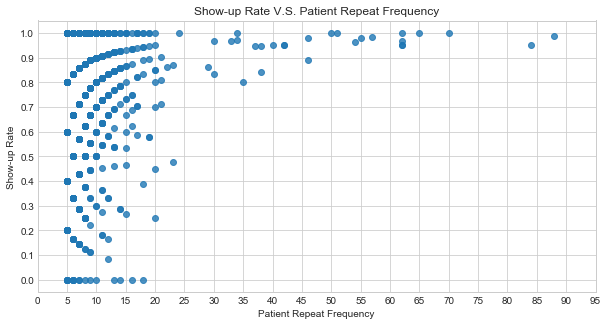

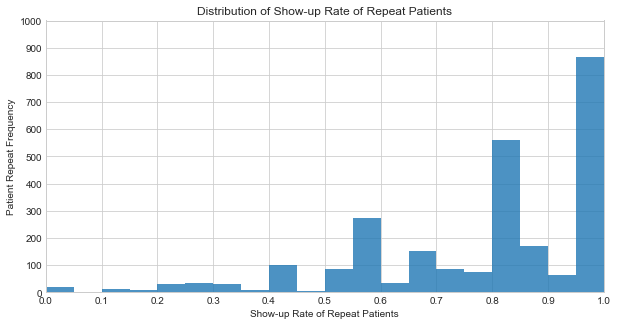

Percentage of repeat patients(frequency >= 5): 2.37%


In [464]:
# count patient repeat frequency and their show-up rate
patient_count = dummy_analysis.groupby(['PatientId']).Status.count()
patient_count.name = 'Count'
patient_mean = dummy_analysis.groupby(['PatientId']).Status.mean()
patient_mean.name = 'Showup_Rate'

# select patients who repeat greater or equal to 5 times
patient_analysis = pd.concat([patient_count, patient_mean], axis=1)
patient_analysis = patient_analysis[patient_analysis.Count>=5]

# plot Show-up Rate V.S. Patient Repeat Frequency
plt.figure(figsize=(10,5))
sns.regplot(x="Count", y="Showup_Rate", data=patient_analysis, ci=False, fit_reg=False)
plt.xticks(np.arange(0,100,5))
plt.yticks(np.arange(0,1.1,0.1))
plt.title("Show-up Rate V.S. Patient Repeat Frequency")
plt.xlabel('Patient Repeat Frequency')
plt.ylabel('Show-up Rate')
plt.show()

# plot Distribution of Show-up Rate of Repeat Patients
plt.figure(figsize=(10,5))
patient_analysis.Showup_Rate.hist(bins=20, alpha=0.8)
plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1100,100))
plt.title("Distribution of Show-up Rate of Repeat Patients")
plt.xlabel('Show-up Rate of Repeat Patients')
plt.ylabel('Patient Repeat Frequency')
plt.show()

print(f'Percentage of repeat patients(frequency >= 5): {round(100*len(patient_analysis)/len(data),2)}%')

Show-up Rate V.S. Patient Repeat Frequency shows a clear convergence trend. As patient repeat frequency become higher, the show-up rate converge to 1.

According to the distribution of Show-up Rate of Repeat Patients, majority of repeat patients went for their scheduled appoinments.

However, because the number of repeat patients (frequency >= 5) is only a small part in the entire data set, PatientId may not play an important role in determining if a patient comes for a visit or not.

### 4. Building Models on Imbalanced Data

From the EDA we see that there are around 80% of the patients who have turned up. We see a clear class imbalance problem here. A naive approach of predicting that every one shows up gives us an accuracy of 0.8. Below we shall see how well the classifiers score on this dataset.

#### Transforming the Data Set

In order to test how well a ML model can predict the 'No-show' patients,
I set 'No-show' as positive class (1), 'Show-up' as negative class (0).

In [549]:
# transfrom category variables
le = preprocessing.LabelEncoder()

data.Status = (data.Status == 'No-show').astype(int)

data.Gender = le.fit_transform(data.Gender)
data.PatientId = le.fit_transform(data.PatientId)
data.Neighbourhood = le.fit_transform(data.Neighbourhood)
data.ScheduledDay_Month = le.fit_transform(data.ScheduledDay_Month)

#### Define Feature Matrix and Target Array

According to analysis result from EDA and after some features tuning, I selected below attributes as the predictors.

In [590]:
# select attributes for machine learning models
X = data.loc[:,['PatientId', 'Gender', "Age", 'Scholarship', 'Hipertension', 'Diabetes', 'Handcap', "Neighbourhood", "ScheduledDay_Month", "Awaiting_Days", "Handicap", "If_0Await", "If_ScheduledMonth56"]]
y = data['Status']

In [467]:
# display feature matrix and target array
pd.concat([X,y], axis=1).rename({"0":"Status"}).head()

,PatientId,Gender,Age,Scholarship,Hipertension,Diabetes,Handcap,Neighbourhood,ScheduledDay_Month,Awaiting_Days,Handicap,If_0Await,If_ScheduledMonth56,Status
0,30845,0,62,0,1,0,0,39,5,0,0,1,0,0
1,55324,1,56,0,0,0,0,39,5,0,0,1,0,0
2,15722,0,62,0,0,0,0,45,5,0,0,1,0,0
3,9018,0,8,0,0,0,0,54,5,0,0,1,0,0
4,23941,0,56,0,1,1,0,39,5,0,0,1,0,0


#### Prepare Data for Model Training

In data preparation, I randomly selected 5000 data from model data set to create a smaller data set for gridsearch. I also created train and test data by splitting the model data set to 80-20.

In [591]:
# perform gridsearch on a smaller sampled dataset(otherwise it takes forever to run)
random_index = random.sample(list(range(len(data))), 5000)
X = X.values
y = y.values

# split data set to train and test(80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Train Model - Logistic Regression

I followed below steps to assess the model(logistic regression) on imbalanced data set:
1. perform grid search on selected sample dataset
2. perform cross validation on model with parameters calculated from grid search
3. calculate accuracy score from Train-Test Split(80-20)
4. calculate precision score (What percentage of 'No-show' instances has been correctly predicted in total **predicted** 'No-show' instances)
5. calculate recall score (What percentage of 'No-show' instances has been correctly predicted in total **true** 'No-show' instances)
6. calculate F1 score
7. calculate accuracy of positive/negative class (What percentage of 'No-show'/'Show-up' have been correctly predicted in their own **true** class instances)
8. calculate precision-recall curve and precision-recall score

In [592]:
# Grid Search on selected sample dataset
param_grid = {"penalty": ['l1', 'l2']
              ,"C" : [0.01, 0.1, 1, 10, 100]}

clf_log = LogisticRegression()
clf_log = GridSearchCV(clf_log, param_grid, cv=5, scoring='accuracy')
clf_log.fit(X[random_index], y[random_index])
print(clf_log.best_params_)

{'C': 100, 'penalty': 'l1'}


In [593]:
# Perform cross validation on Logistic Regression model with parameters calculated from Grid Search
log = clf_log.best_estimator_
log.fit(X, y)
CVscore = cross_val_score(log, X, y, cv=5)
log_CVscore = CVscore.mean()
print(f' Cross validation scores: {CVscore}')
print(f' Average score: {log_CVscore}')

 Cross validation scores: [ 0.79809998  0.79814522  0.79777416  0.79809084  0.79821744]
 Average score: 0.7980655263503724


 Train-Test Split(80-20) accuracy score: 0.7975118751413708
 Precision score: 0.2857142857142857
 Recall score: 0.0008948545861297539
 F1 score: 0.0017841213202497768
 Accuracy of positive class: 0.00089485458613
 Accuracy of negative class: 0.999432945846
 Average precision-recall score: 0.33


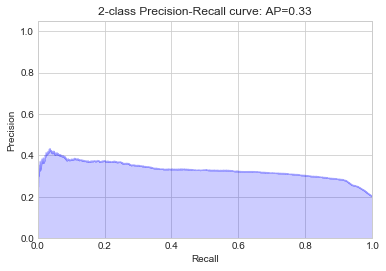

In [604]:
# Feed Logistic Regression model
log = clf_log.best_estimator_
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

# Accuracy score from Train-Test Split(80-20)
log_score = accuracy_score(y_pred, y_test)
print(f' Train-Test Split(80-20) accuracy score: {log_score}')

# Precision score
log_precision_score = precision_score(y_test, y_pred)
print(f' Precision score: {log_precision_score}')

# Recall score
log_recall_score = recall_score(y_test, y_pred)
print(f' Recall score: {log_recall_score}')

# F1 score
log_f1 = f1_score(y_test, y_pred)
print(f' F1 score: {log_f1}')

# Confusion matrix: Accuracy of positive/negative class
conf_matrix = confusion_matrix(y_test, y_pred)
log_acc_p = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
log_acc_n = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print(" Accuracy of positive class:",log_acc_p)
print(" Accuracy of negative class:",log_acc_n)

# Precision-Recall curve and precision-recall score
y_score = clf_log.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
print(' Average precision-recall score: {0:0.2f}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

# store results to log_result
log_result_imbalanced = np.round([log_CVscore, log_score, log_precision_score, log_recall_score, log_f1, log_acc_p, log_acc_n],3)

From the above CV and accuracy score we can see that we are doing almost similar to the naive predictor. 

If you look at the accuracy of positive/negative class, you will find that the model predicted almost all instances to 'Show-up' but few 'No-show'. The precision score of 'No-show' is too low to prove model's ability on predicting 'No-show'.

The F1 and average precision-recall score show that the model is pretty bad on predicting. It maybe even better to just use naive predictor. Therefore, in this case, we are difficult to extract essence from the model.

### 5. Building Models on Balanced Data

#### Create Balanced Data Set

We can change the dataset that we use to build the predictive model to have more balanced data.

This change is called sampling dataset and there are two main methods that we can use to even-up the classes:

1. Adding copies of instances from the under-represented class called over-sampling (or more formally sampling with replacement), or
2. Deleting instances from the over-represented class, called under-sampling.

Because data volumn is large enough, in this case, I will use the second method, under-sampling.

In [472]:
# randomly delete 65893 instances from the over-represented class(Show-up)
delete_instances = random.sample(list(data[data.Status == 0].index), 65893)
data_balanced = data.drop(delete_instances)

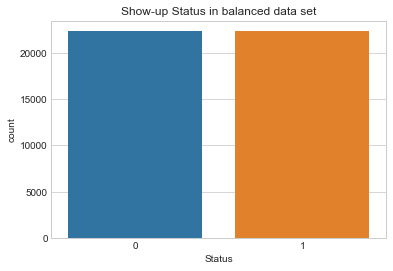

Percentage of Status(0 Show-up, 1 No-show): 


1    50.0
0    50.0
Name: Status, dtype: float64

In [605]:
# plot distribution of Show-up Status in balanced data set
sns.countplot(x="Status", data=data_balanced)
plt.title("Show-up Status in balanced data set")
plt.show()
print("Percentage of Status(0 Show-up, 1 No-show): ")
100 * data_balanced['Status'].value_counts()/len(data_balanced)

#### Prepare Data for Model Training

In [646]:
# select attributes for machine learning models (same as last part)
X = data_balanced.loc[:,['PatientId', 'Gender', "Age", 'Scholarship', 'Hipertension', 'Diabetes', 'Handcap', "Neighbourhood", "ScheduledDay_Month", "Awaiting_Days", "Handicap", "If_0Await", "If_ScheduledMonth56"]]
y = data_balanced['Status']

# perform gridsearch on a smaller sampled dataset(otherwise it takes forever to run)
random_index = random.sample(list(range(len(data_balanced))), 5000)
X = X.values
y = y.values

# split data set to train and test(80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

I followed below steps to assess models on balanced data set:

1. perform grid search on selected sample dataset
2. perform cross validation on model with parameters calculated from grid search
3. calculate accuracy score from Train-Test Split(80-20)
4. calculate precision score (What percentage of 'No-show' instances has been correctly predicted in total **predicted** 'No-show' instances)
5. calculate recall score (What percentage of 'No-show' instances has been correctly predicted in total **true** 'No-show' instances)
6. calculate F1 score
7. calculate accuracy of positive/negative class (What percentage of 'No-show'/'Show-up' have been correctly predicted in their own **true** class instances)

#### Logistic Regression

In [647]:
# Grid Search on selected sample dataset
param_grid = {"penalty": ['l1', 'l2']
              ,"C" : [0.01, 0.1, 1, 10, 100]}

clf_log = LogisticRegression()
clf_log = GridSearchCV(clf_log, param_grid, cv=5, scoring='accuracy')
clf_log.fit(X[random_index], y[random_index])
print(clf_log.best_params_)

{'C': 1, 'penalty': 'l1'}


In [648]:
# Perform cross validation on Logistic Regression model with parameters calculated from Grid Search
log = clf_log.best_estimator_
log.fit(X, y)
CVscore = cross_val_score(log, X, y, cv=5)
log_CVscore = CVscore.mean()
print(f' Cross validation scores: {CVscore}')
print(f' Average score: {log_CVscore}')

 Cross validation scores: [ 0.66726417  0.67947569  0.64485772  0.69639256  0.66461228]
 Average score: 0.6705204845297553


In [649]:
# Feed Logistic Regression model
log = clf_log.best_estimator_
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

# Accuracy score from Train-Test Split(80-20)
log_score = accuracy_score(y_pred, y_test)
print(f' Train-Test Split(80-20) accuracy score: {log_score}')

# Precision score
log_precision_score = precision_score(y_test, y_pred)
print(f' Precision score: {log_precision_score}')

# Recall score
log_recall_score = recall_score(y_test, y_pred)
print(f' Recall score: {log_recall_score}')

# F1 score
log_f1 = f1_score(y_test, y_pred)
print(f' F1 score: {log_f1}')

# Confusion matrix: Accuracy of positive/negative class
conf_matrix = confusion_matrix(y_test, y_pred)
log_acc_p = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
log_acc_n = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print(" Accuracy of positive class:",log_acc_p)
print(" Accuracy of negative class:",log_acc_n)

 Train-Test Split(80-20) accuracy score: 0.6681604302038987
 Precision score: 0.6167626359564939
 Recall score: 0.872003618272275
 F1 score: 0.7225032789956904
 Accuracy of positive class: 0.872003618272
 Accuracy of negative class: 0.468028419183


#### Decision Tree Classifier

In [478]:
# Grid Search on selected sample dataset
param_grid = {"max_depth": list(np.arange(2,11,1))
              ,"min_samples_split" : list(np.arange(2,21,1))
              ,"min_samples_leaf": list(np.arange(2,21,1))
              ,"max_features": list(np.arange(2,14,1))}

clf_dt = DecisionTreeClassifier()
clf_dt = GridSearchCV(clf_dt, param_grid, cv=5, scoring='accuracy')
clf_dt.fit(X[random_index], y[random_index])
print(clf_dt.best_params_)

{'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 8, 'min_samples_split': 12}


In [479]:
# Perform cross validation on Decision Tree model with parameters calculated from Grid Search
dt = clf_dt.best_estimator_
dt.fit(X, y)
CVscore = cross_val_score(dt, X, y, cv=5)
dt_CVscore = CVscore.mean()
print(f' Cross validation scores: {CVscore}')
print(f' Average score: {dt_CVscore}')

 Cross validation scores: [ 0.64676227  0.68216446  0.6472104   0.69672866  0.64545047]
 Average score: 0.6636632511974295


In [480]:
# Perform further validation metrics on Decision Tree model with parameters calculated from Grid Search
dt = clf_dt.best_estimator_
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# Accuracy score from Train-Test Split(80-20)
dt_score = accuracy_score(y_pred, y_test)
print(f' Train-Test Split(80-20) accuracy score: {dt_score}')

# Precision score
dt_precision_score = precision_score(y_test, y_pred)
print(f' Precision score: {dt_precision_score}')

# Recall score
dt_recall_score = recall_score(y_test, y_pred)
print(f' Recall score: {dt_recall_score}')

# F1 score
dt_f1 = f1_score(y_test, y_pred)
print(f' F1 score: {dt_f1}')

# Confusion matrix: Accuracy of positive/negative class
conf_matrix = confusion_matrix(y_test, y_pred)
dt_acc_p = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
dt_acc_n = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print(" Accuracy of positive class:",dt_acc_p)
print(" Accuracy of negative class:",dt_acc_n)

 Train-Test Split(80-20) accuracy score: 0.6774591082231682
 Precision score: 0.6275734053324333
 Recall score: 0.8469596902755636
 F1 score: 0.7209460114374333
 Accuracy of positive class: 0.846959690276
 Accuracy of negative class: 0.513340683572


#### Random Forest Classifier

In [481]:
# Grid Search on selected sample dataset
param_grid = {"max_depth": list(np.arange(2,11,1))
              ,"min_samples_split" : list(np.arange(2,21,1))
              ,"min_samples_leaf": list(np.arange(2,21,1))
              ,"max_features": list(np.arange(2,14,1))}

clf_rf = RandomForestClassifier()
clf_rf = GridSearchCV(clf_rf, param_grid, cv=5, scoring='accuracy')
clf_rf.fit(X[random_index], y[random_index])
print(clf_rf.best_params_)

{'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 18, 'min_samples_split': 10}


In [482]:
# Perform cross validation on RandomForest model with parameters calculated from Grid Search
rf = clf_rf.best_estimator_
rf.fit(X, y)
CVscore = cross_val_score(rf, X, y, cv=5)
rf_CVscore = CVscore.mean()
print(f' Cross validation scores: {CVscore}')
print(f' Average score: {rf_CVscore}')

 Cross validation scores: [ 0.67185749  0.67958772  0.64452162  0.67689895  0.64780368]
 Average score: 0.6641338921656053


In [483]:
# Perform further validation metrics on RandomForest model with parameters calculated from Grid Search
rf = clf_rf.best_estimator_
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Accuracy score from Train-Test Split(80-20)
rf_score = accuracy_score(y_pred, y_test)
print(f' Train-Test Split(80-20) accuracy score: {rf_score}')

# Precision score
rf_precision_score = precision_score(y_test, y_pred)
print(f' Precision score: {rf_precision_score}')

# Recall score
rf_recall_score = recall_score(y_test, y_pred)
print(f' Recall score: {rf_recall_score}')

# F1 score
rf_f1 = f1_score(y_test, y_pred)
print(f' F1 score: {rf_f1}')

# Confusion matrix: Accuracy of positive/negative class
conf_matrix = confusion_matrix(y_test, y_pred)
rf_acc_p = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
rf_acc_n = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print(" Accuracy of positive class:",rf_acc_p)
print(" Accuracy of negative class:",rf_acc_n)

 Train-Test Split(80-20) accuracy score: 0.6783553663455075
 Precision score: 0.6288572397422855
 Recall score: 0.8446823047141881
 F1 score: 0.7209641364564097
 Accuracy of positive class: 0.844682304714
 Accuracy of negative class: 0.517309812569


#### Gradient Boosting Classifier

In [484]:
# Grid Search on selected sample dataset
param_grid = {'loss' : ["deviance"],
              'n_estimators' : [50, 100,150],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8, 12],
              'min_samples_leaf': [2, 6, 10],
              'min_samples_split': [2, 6, 10],
              'max_features': ['sqrt','log2',None]}

clf_gbc = GradientBoostingClassifier()
clf_gbc = GridSearchCV(clf_gbc, param_grid, cv=5, scoring='accuracy')
clf_gbc.fit(X[random_index], y[random_index])
print(clf_gbc.best_params_)

{'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}


In [485]:
# Perform cross validation on Gradient Boosting Optimization with parameters calculated from Grid Search
gbc = clf_gbc.best_estimator_
gbc.fit(X, y)
CVscore = cross_val_score(gbc, X, y, cv=5)
gbc_CVscore = CVscore.mean()
print(f' Cross validation scores: {CVscore}')
print(f' Average score: {gbc_CVscore}')

 Cross validation scores: [ 0.66972888  0.68093211  0.64821869  0.67208156  0.65553563]
 Average score: 0.6652993742161885


In [486]:
# Perform further validation metrics on Gradient Boosting model with parameters calculated from Grid Search
gbc = clf_gbc.best_estimator_
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

# Accuracy score from Train-Test Split(80-20)
gbc_score = accuracy_score(y_pred, y_test)
print(f' Train-Test Split(80-20) accuracy score: {gbc_score}')

# Precision score
gbc_precision_score = precision_score(y_test, y_pred)
print(f' Precision score: {gbc_precision_score}')

# Recall score
gbc_recall_score = recall_score(y_test, y_pred)
print(f' Recall score: {gbc_recall_score}')

# F1 score
gbc_f1 = f1_score(y_test, y_pred)
print(f' F1 score: {gbc_f1}')

# Confusion matrix: Accuracy of positive/negative class
conf_matrix = confusion_matrix(y_test, y_pred)
gbc_acc_p = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
gbc_acc_n = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print(" Accuracy of positive class:",gbc_acc_p)
print(" Accuracy of negative class:",gbc_acc_n)

 Train-Test Split(80-20) accuracy score: 0.6782433340802151
 Precision score: 0.6279696714406066
 Recall score: 0.8487815987246641
 F1 score: 0.7218671315126863
 Accuracy of positive class: 0.848781598725
 Accuracy of negative class: 0.513120176406


#### Extra Trees Classifier

In [487]:
# Grid Search on selected sample dataset
param_grid = {"max_depth": [5,10,15],
              "max_features": ['sqrt','log2','auto'],
              "min_samples_split": [2, 6, 10],
              "min_samples_leaf": [2, 6, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300,500],
              "criterion": ["gini"]}

clf_et = ExtraTreesClassifier()
clf_et = GridSearchCV(clf_et, param_grid, cv=5, scoring='accuracy')
clf_et.fit(X[random_index], y[random_index])
print(clf_et.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [488]:
# Perform cross validation on Extra Trees model with parameters calculated from Grid Search
et = clf_et.best_estimator_
et.fit(X, y)
CVscore = cross_val_score(et, X, y, cv=5)
et_CVscore = CVscore.mean()
print(f' Cross validation scores: {CVscore}')
print(f' Average score: {et_CVscore}')

 Cross validation scores: [ 0.66659198  0.67947569  0.64138472  0.69840914  0.65161363]
 Average score: 0.6674950308593403


In [489]:
# Perform further validation metrics on Extra Trees model with parameters calculated from Grid Search
et = clf_et.best_estimator_
et.fit(X_train, y_train)
y_pred = et.predict(X_test)

# Accuracy score from Train-Test Split(80-20)
et_score = accuracy_score(y_pred, y_test)
print(f' Train-Test Split(80-20) accuracy score: {et_score}')

# Precision score
et_precision_score = precision_score(y_test, y_pred)
print(f' Precision score: {et_precision_score}')

# Recall score
et_recall_score = recall_score(y_test, y_pred)
print(f' Recall score: {et_recall_score}')

# F1 score
et_f1 = f1_score(y_test, y_pred)
print(f' F1 score: {et_f1}')

# Confusion matrix: Accuracy of positive/negative class
conf_matrix = confusion_matrix(y_test, y_pred)
et_acc_p = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
et_acc_n = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print(" Accuracy of positive class:",et_acc_p)
print(" Accuracy of negative class:",et_acc_n)

 Train-Test Split(80-20) accuracy score: 0.6725296885503025
 Precision score: 0.612645794966237
 Recall score: 0.9091323161011159
 F1 score: 0.7320069680022003
 Accuracy of positive class: 0.909132316101
 Accuracy of negative class: 0.443439911797


#### K-Nearest Neighbors Classifier

In [490]:
# Grid Search on selected sample dataset
param_grid = {"n_neighbors": list(np.arange(2,31,1))
              ,"weights" : ["uniform", "distance"]
              ,"leaf_size": list(np.arange(2,21,1))}

clf_knn = KNeighborsClassifier()
clf_knn = GridSearchCV(clf_knn, param_grid, cv=5, scoring='accuracy')
clf_knn.fit(X[random_index], y[random_index])
print(clf_knn.best_params_)

{'leaf_size': 2, 'n_neighbors': 2, 'weights': 'distance'}


In [491]:
# Perform cross validation on KNN model with parameters calculated from Grid Search
knn = clf_knn.best_estimator_
knn.fit(X, y)
CVscore = cross_val_score(knn, X, y, cv=5)
knn_CVscore = CVscore.mean()
print(f' Cross validation scores: {CVscore}')
print(f' Average score: {knn_CVscore}')

 Cross validation scores: [ 0.5524311   0.54638136  0.54649339  0.54190007  0.55445988]
 Average score: 0.5483331597527878


In [492]:
# Perform further validation metrics on KNN model with parameters calculated from Grid Search
knn = clf_knn.best_estimator_
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Accuracy score from Train-Test Split(80-20)
knn_score = accuracy_score(y_pred, y_test)
print(f' Train-Test Split(80-20) accuracy score: {knn_score}')

# Precision score
knn_precision_score = precision_score(y_test, y_pred)
print(f' Precision score: {knn_precision_score}')

# Recall score
knn_recall_score = recall_score(y_test, y_pred)
print(f' Recall score: {knn_recall_score}')

# F1 score
knn_f1 = f1_score(y_test, y_pred)
print(f' F1 score: {knn_f1}')

# Confusion matrix: Accuracy of positive/negative class
conf_matrix = confusion_matrix(y_test, y_pred)
knn_acc_p = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
knn_acc_n = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print(" Accuracy of positive class:",knn_acc_p)
print(" Accuracy of negative class:",knn_acc_n)

 Train-Test Split(80-20) accuracy score: 0.5665471655836881
 Precision score: 0.5584415584415584
 Recall score: 0.5679799590070599
 F1 score: 0.5631703737157051
 Accuracy of positive class: 0.567979959007
 Accuracy of negative class: 0.565159867696


### 6. Conclusion

#### Result Summary

In [650]:
# build a dataframe for model results
log_result = np.round([log_CVscore, log_score, log_precision_score, log_recall_score, log_f1, log_acc_p, log_acc_n],3)
dt_result = np.round([dt_CVscore, dt_score, dt_precision_score, dt_recall_score, dt_f1, dt_acc_p, dt_acc_n],3)
rf_result = np.round([rf_CVscore, rf_score, rf_precision_score, rf_recall_score, rf_f1, rf_acc_p, rf_acc_n],3)
gbc_result = np.round([gbc_CVscore, gbc_score, gbc_precision_score, gbc_recall_score, gbc_f1, gbc_acc_p, gbc_acc_n],3)
et_result = np.round([et_CVscore, et_score, et_precision_score, et_recall_score, et_f1, et_acc_p, et_acc_n],3)
knn_result = np.round([knn_CVscore, knn_score, knn_precision_score, knn_recall_score, knn_f1, knn_acc_p, knn_acc_n],3)

ml_results = pd.DataFrame([log_result_imbalanced, log_result, dt_result, rf_result, gbc_result, et_result, knn_result], 
                          columns=['CV_Score', 'Accuracy_Score', 'Precision_Score', 'Recall_Score', 'F1_Score', 'Accuracy_NoShow', 'Accuracy_ShowUp'],
                          index=['Imbalanced_Log', 'Logistic_Regr', 'Decision_Tree', 'Random_Forest', 'Gradient_Boosting', 'Extra_Trees', 'KNearest_Neig'])

ml_results

,CV_Score,Accuracy_Score,Precision_Score,Recall_Score,F1_Score,Accuracy_NoShow,Accuracy_ShowUp
Imbalanced_Log,0.798,0.798,0.286,0.001,0.002,0.001,0.999
Logistic_Regr,0.671,0.668,0.617,0.872,0.723,0.872,0.468
Decision_Tree,0.664,0.677,0.628,0.847,0.721,0.847,0.513
Random_Forest,0.664,0.678,0.629,0.845,0.721,0.845,0.517
Gradient_Boosting,0.665,0.678,0.628,0.849,0.722,0.849,0.513
Extra_Trees,0.667,0.673,0.613,0.909,0.732,0.909,0.443
KNearest_Neig,0.548,0.567,0.558,0.568,0.563,0.568,0.565


- If stackholder want to simply maximize true negative rate(Show-up accuracy) and is not concern with true positive rate(No-show accuracy), I would suggest to use the Logistic Regression model on the imbalanced data set(I've tried different models on imbalanced data set, they performed similar results).
- If stackholder want to optimize true positive rate(No-show accuracy) in the superior true negative rate(Show-up accuracy), I would suggest to use the Random Forest or the Gradient Boosting model on the balanced data set.
- If stackholder want to optimize true negative rate(Show-up accuracy) in the superior true positive rate(No-show accuracy), I would suggest to use the Extra Trees or Logistic Regression model on the balanced data set.

#### Features Importance

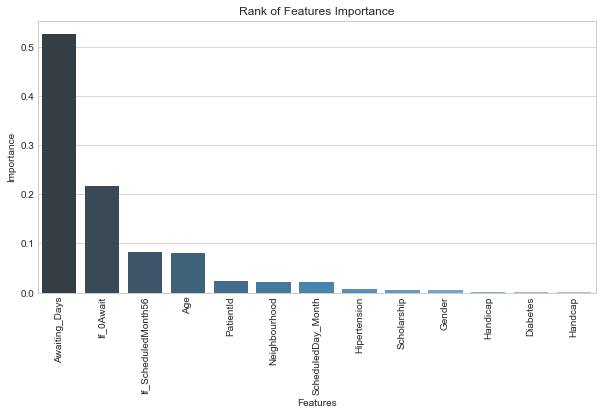

In [704]:
# features importance from random forest model
features_name = ['PatientId', 'Gender', "Age", 'Scholarship', 'Hipertension', 'Diabetes', 'Handcap', "Neighbourhood", "ScheduledDay_Month", "Awaiting_Days", "Handicap", "If_0Await", "If_ScheduledMonth56"]
features_importance = pd.DataFrame([features_name, list(rf.feature_importances_)], index=['Feature', 'Importance']).T
features_importance = features_importance.sort_values(by=['Importance'], ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Feature", y="Importance", data=features_importance, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Rank of Features Importance")
plt.xlabel('Features')
plt.ylabel("Importance")
plt.show()

From the above feature importance, we could see that Awaiting Days, If patient schdules appointment on the same day, If patient schdules appointment in May and June and patient's age are some of the top features that would help us determine if the patient who has taken an appointment will Show/NoShow.

#### Interesting Findings

- On average, female are twice as likely to visit the doctor than male.
- Most patients are planned their appointment few days in advance or even in the same day.
- Children(age 0-14)'s show-up rate are negatively related to age; Youth and middle-aged people(age 15-65)'s show-up rate are positively related to age.
- Patients who schduled his/her appointments in shorter awaiting period tend to visit the hospital more than those who schduled longer. This trend is correct till the awaiting period is greater than 10 days.
- Certain patients were more likely to miss their appointments than other patients. Those who missed an appointment showed a much higher frequency of also missing the next.

### 7. Limitations

- From the data we can see that the Appointment time spans just over few months which means that we were given only a snapshot of complete data. Though there are no null values in the data, making exact predictions and analysis on a snapshot data is difficult and the analysis might not make a representation of the whole data.

- Another very important thing that was missing from the data is the Time details in the AppointmentDay which would really help us a lot in predicting NoShow of a patient. As we have the time detail for ScheduledDay, we should have saved the similar thing in AppointmentDay also and not just normalize it.

- The meaning of SMS_received could be better defined. People who do receive a reminder SMS usually tend to visit the hospital more than those who haven't received an SMS. It conflict with common sense.

- Also, a reason for the appointment and the consultation doctor specialization would help us a lot in making better analysis and predictions for the NoShow of a patient. 

### 8. Future Work

1. More sampling techniques could be used to train models such as SMOTE(over-sampling) and Balance Cascade(under-sdampling).
2. Imbalanced problem could be better sovled by more creative way such as decomposing larger class into smaller number of other classes.
3. Model Parameters cound be better tuned; More kinds of model could be used to compare.
4. Model features could be better designed/chose by performing more creative EDA/choosing techniques.

### 9. Reference

- http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
- https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/